# Figures 

## ECCO

In [1]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline
import gsw
from fastjmd95 import jmd95numba
from fastjmd95 import rho, drhods, drhodt
import json

In [2]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [3]:
omega_total = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/wmt_budget_terms/omega_total_newbins.zarr'))
R1 = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/wmt_budget_terms/R1_newbins.zarr'))

In [4]:
wmt_budget_terms = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/wmt_budget_terms_newbins.zarr'))
wmt_budget_terms.load()

<xarray.Dataset>
Dimensions:               (time: 286, sigma2_bin: 99)
Coordinates:
  * sigma2_bin            (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03
  * time                  (time) datetime64[ns] 1992-02-13 ... 2015-11-14
    time_snp              (time) datetime64[ns] 1992-03-01 ... 2015-12-01
Data variables: (12/18)
    R1                    (time, sigma2_bin) float64 1.64e+06 ... -5.713e+04
    R2                    (time, sigma2_bin) float64 -2.276e+06 ... -8.799e+04
    R3                    (time, sigma2_bin) float64 -9.906e+03 ... -1.468e+03
    dVdt                  (time, sigma2_bin) float32 -1.173e+07 ... -9.151e+04
    omega_mix             (time, sigma2_bin) float64 -9.24e+06 ... -2.976e+03
    omega_mix_slt         (time, sigma2_bin) float64 -3.099e+06 ... -8.984e+03
    ...                    ...
    omega_total_th        (time, sigma2_bin) float64 -8.363e+06 ... 1.814e+04
    omega_trans_rate      (time, sigma2_bin) float64 -1.052e+07 ... 5.508e+04
    omega_trans_rate_slt  (time, sigma2_bin) float64 -2.639e+06 ... 4.907e+04
    omega_trans_rate_th   (time, sigma2_bin) float64 -7.883e+06 ... 6.008e+03
    psi_adv               (time, sigma2_bin) float64 -2.833e+06 ... -8.799e+04
    psi_vel               (time, sigma2_bin) float32 -5.575e+05 ... -0.0

In [5]:
wmt_budget_terms.coords

Coordinates:
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03
  * time        (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14
    time_snp    (time) datetime64[ns] 1992-03-01 1992-04-01 ... 2015-12-01

In [6]:
omega_total.omega_total[:-1]

<xarray.DataArray 'omega_total' (time: 286, sigma2_bin: 99)>
dask.array<getitem, shape=(286, 99), dtype=float64, chunksize=(286, 99), chunktype=numpy.ndarray>
Coordinates:
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03
  * time        (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

In [7]:
R1.coords

Coordinates:
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03
  * time        (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14
    time_snp    (time) datetime64[ns] dask.array<chunksize=(286,), meta=np.ndarray>

In [8]:
wmt_budget_terms['omega_total'] = omega_total.omega_total[:-1]
wmt_budget_terms['R1'] = R1.R1

In [9]:
wmt_budget_terms

<xarray.Dataset>
Dimensions:               (sigma2_bin: 99, time: 286)
Coordinates:
  * sigma2_bin            (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03
  * time                  (time) datetime64[ns] 1992-02-13 ... 2015-11-14
    time_snp              (time) datetime64[ns] 1992-03-01 ... 2015-12-01
Data variables: (12/18)
    R1                    (time, sigma2_bin) float64 dask.array<chunksize=(286, 99), meta=np.ndarray>
    R2                    (time, sigma2_bin) float64 -2.276e+06 ... -8.799e+04
    R3                    (time, sigma2_bin) float64 -9.906e+03 ... -1.468e+03
    dVdt                  (time, sigma2_bin) float32 -1.173e+07 ... -9.151e+04
    omega_mix             (time, sigma2_bin) float64 -9.24e+06 ... -2.976e+03
    omega_mix_slt         (time, sigma2_bin) float64 -3.099e+06 ... -8.984e+03
    ...                    ...
    omega_total_th        (time, sigma2_bin) float64 -8.363e+06 ... 1.814e+04
    omega_trans_rate      (time, sigma2_bin) float64 -1.052e+07 ... 5.508e+04
    omega_trans_rate_slt  (time, sigma2_bin) float64 -2.639e+06 ... 4.907e+04
    omega_trans_rate_th   (time, sigma2_bin) float64 -7.883e+06 ... 6.008e+03
    psi_adv               (time, sigma2_bin) float64 -2.833e+06 ... -8.799e+04
    psi_vel               (time, sigma2_bin) float32 -5.575e+05 ... -0.0

## Time mean budgets

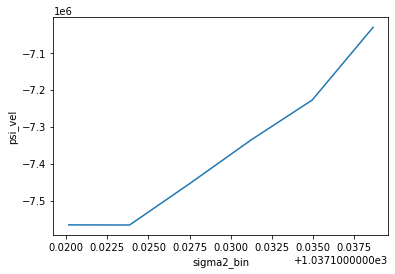

In [15]:
wmt_budget_terms.psi_vel.mean('time').sel(sigma2_bin=slice(1037.12, 1037.14)).plot()

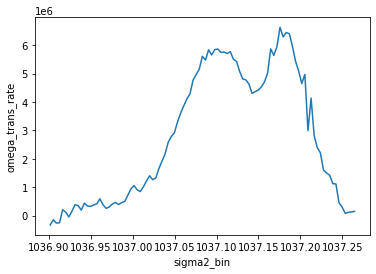

In [16]:
wmt_budget_terms.omega_trans_rate.mean('time').plot()

In [18]:
(wmt_budget_terms.omega_trans_rate.mean('time')[-1] - wmt_budget_terms.omega_trans_rate.mean('time').sel(sigma2_bin=1037.12, method='nearest'))/1e6

<xarray.DataArray 'omega_trans_rate' ()>
array(-5.34814462)

In [19]:
(wmt_budget_terms.omega_trans_rate.mean('time')[0] - wmt_budget_terms.omega_trans_rate.mean('time').sel(sigma2_bin=1037.12, method='nearest'))/1e6

<xarray.DataArray 'omega_trans_rate' ()>
array(-5.82737966)

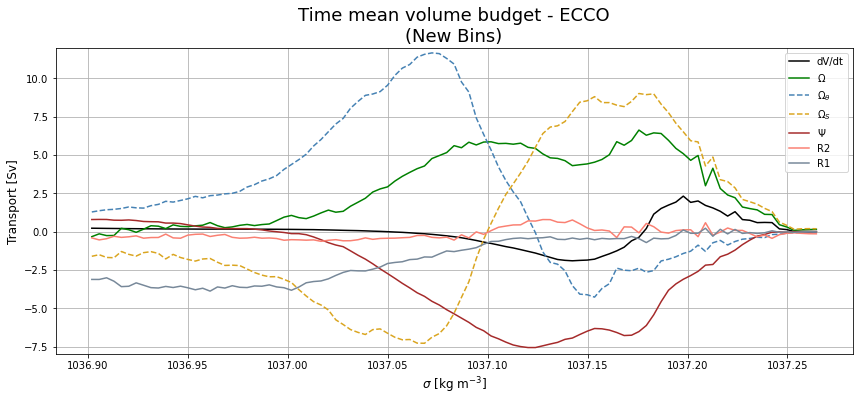

In [20]:
(wmt_budget_terms.dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', figsize=(12,5))
(wmt_budget_terms.omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega$', color='green')
(wmt_budget_terms.omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', color='steelblue', linestyle='dashed')
(wmt_budget_terms.omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', color='goldenrod', linestyle='dashed')
(wmt_budget_terms.psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', color='brown')
(wmt_budget_terms.R2/1e6).mean(dim='time').plot(label='R2', color='salmon')
(wmt_budget_terms.R1/1e6).mean(dim='time').plot(label='R1', color='lightslategray')
#(R3[1:-1]/1e6).mean(dim='time').plot(label=r'$R3$', color='mediumspringgreen')
plt.legend()
plt.grid()
plt.ylim(-8, 12)
#plt.xlim(1037.0, 1037.2)
plt.tight_layout()
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
plt.ylabel(r'Transport [Sv]', fontsize=12)
plt.title('Time mean volume budget - ECCO\n(New Bins)', fontsize=18);

In [21]:
def d_dsigma(da):
    """d/dsigma function to switch to formation view"""
    da = (da.diff('sigma2_bin') / wmt_budget_terms.sigma2_bin.diff('sigma2_bin')) / 1e6
    return da

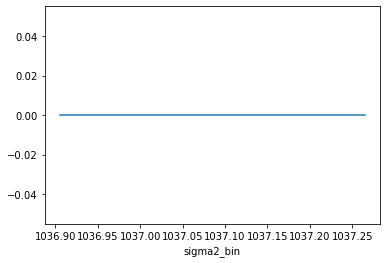

In [22]:
#check function works
(((wmt_budget_terms.omega_trans_rate.diff('sigma2_bin') / wmt_budget_terms.sigma2_bin.diff('sigma2_bin'))/1e6) - 
 d_dsigma(wmt_budget_terms.omega_trans_rate)).mean('time').plot();
#it works

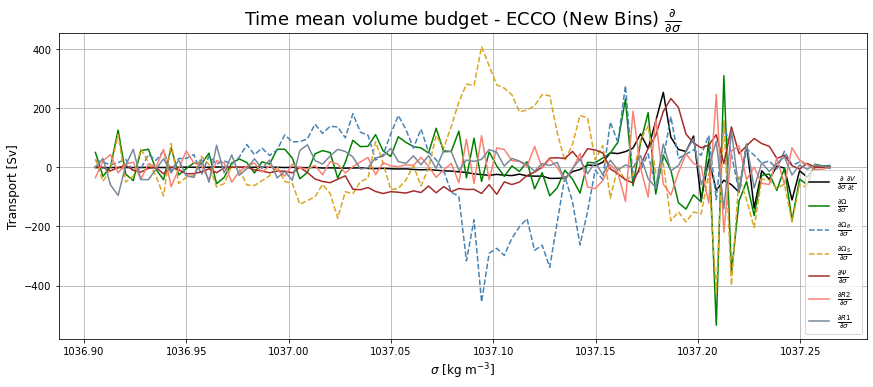

In [42]:
d_dsigma(wmt_budget_terms.dVdt).mean(dim='time').plot(label=r'$\frac{\partial}{\partial \sigma} \frac{\partial V}{\partial t}}$',
                                                      color='k', figsize=(12,5))
d_dsigma(wmt_budget_terms.omega_trans_rate).mean(dim='time').plot(label=r'$\frac{\partial \Omega}{\partial \sigma}$', color='green')
d_dsigma(wmt_budget_terms.omega_trans_rate_th).mean(dim='time').plot(label=r'$\frac{\partial \Omega_{\theta}}{\partial \sigma}$', 
                                                                     color='steelblue', linestyle='dashed')
d_dsigma(wmt_budget_terms.omega_trans_rate_slt).mean(dim='time').plot(label=r'$\frac{\partial \Omega_S}{\partial \sigma}$', 
                                                                      color='goldenrod', linestyle='dashed')
d_dsigma(wmt_budget_terms.psi_vel).mean(dim='time').plot(label=r'$\frac{\partial \Psi}{\partial \sigma}$', color='brown')
d_dsigma(wmt_budget_terms.R2).mean(dim='time').plot(label=r'$\frac{\partial R2}{\partial \sigma}$', color='salmon')
d_dsigma(wmt_budget_terms.R1).mean(dim='time').plot(label=r'$\frac{\partial R1}{\partial \sigma}$', color='lightslategray')
#(R3[1:-1]/1e6).mean(dim='time').plot(label=r'$R3$', color='mediumspringgreen')
plt.legend()
plt.grid()
#plt.ylim(-8, 12)
#plt.xlim(1037.0, 1037.2)
plt.tight_layout()
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
plt.ylabel(r'Transport [Sv]', fontsize=12)
plt.title(r'Time mean volume budget - ECCO (New Bins) $\frac{\partial}{\partial \sigma}$', fontsize=18);